In [64]:
#by Jules Bonhotal - Joe Toubia - Badreddine Ouar

from typing import Any


class Literal:
    def __init__(self, name, is_negative=False):
        self.name = name
        self.is_negative = is_negative

    def __str__(self):
        if self.is_negative:
            return f"¬{self.name}"
        else:
            return self.name

    def __repr__(self):
        return f"Literal('{self.name}', is_negated={self.is_negative})"

    def __eq__(self, other):
        return isinstance(other, Literal) and self.name == other.name and self.is_negative == other.is_negative

    def __hash__(self):
        return hash((self.name, self.is_negative))


class Rule:
    _rule_count = 0

    def __init__(self, premises, conclusion, is_defeasible=False, reference=None):
        self.premises = [premises] if not isinstance(premises, list) else premises
        self.conclusion = conclusion
        self.is_defeasible = is_defeasible
        if reference is None:
            Rule._rule_count += 1
            self.reference = Literal(f"r{Rule._rule_count}")
        else:
            self.reference = reference

    def __repr__(self):
        premises_str = ", ".join(map(str, self.premises))
        arrow = " => " if self.is_defeasible else " -> "
        return f"[{self.reference}] {premises_str}{arrow}{self.conclusion}"

    def __eq__(self, other):
        return isinstance(other, Rule) and \
               self.premises == other.premises and \
               self.conclusion == other.conclusion and \
               self.is_defeasible == other.is_defeasible and \
               self.reference == other.reference

    def __hash__(self):
        return hash((tuple(self.premises), self.conclusion, self.is_defeasible, self.reference))


class Argument:
    _argument_count = 0

    def __init__(self, top_rule, direct_sub_arguments=None, name=None):
        self.top_rule = top_rule
        self.direct_sub_arguments = direct_sub_arguments or set()
        self.name = name or f"A{Argument._next_argument_id()}"

    @staticmethod
    def _next_argument_id():
        Argument._argument_count += 1
        return Argument._argument_count

    def __str__(self):
        direct_sub_args_str = ", ".join(str(sub_arg) for sub_arg in self.direct_sub_arguments)
        return f"{self.name}: {self.top_rule} | {direct_sub_args_str}"

    def __repr__(self):
        return f" '{self.name}':{self.top_rule} \n"

    def __eq__(self, other):
        return isinstance(other, Argument) and \
               self.top_rule == other.top_rule and \
               self.direct_sub_arguments == other.direct_sub_arguments and \
               self.name == other.name
    def __hash__(self):
        return hash((self.top_rule, frozenset(self.direct_sub_arguments), self.name))

    def defeasible_rules(self, rules):
        defeasible_rules_set = set()
        if self.top_rule.is_defeasible:
           defeasible_rules_set.add(self.top_rule.reference)
        for sub_arg in self.direct_sub_arguments:
               for argument in rules:
                   if argument.name == sub_arg:
                       sub = argument
                       defeasible_rules_set |= sub.defeasible_rules(rules)
                       break
        return defeasible_rules_set

    def last_defeasible_rules(self, rules):
        defeasible_rules_set = set()
        if self.top_rule.is_defeasible:
            defeasible_rules_set.add(self.top_rule.reference)
        else:
            for sub_arg in self.direct_sub_arguments:
                    for argument in rules:
                        if argument.name == sub_arg:
                           defeasible_rules_set |= argument.last_defeasible_rules(rules)


        return defeasible_rules_set

    def all_sub_arguments(self,rules):
        all_sub_arguments_set = set()
        for i in self.direct_sub_arguments:
         all_sub_arguments_set.add(i)
        for sub_arg_name in self.direct_sub_arguments:
            for arg in rules :
                if arg.name == sub_arg_name:
                    all_sub_arguments_set |= arg.all_sub_arguments(rules)

        return all_sub_arguments_set

    def compare_with_preferences(self, args, pref):
        preferred = {}

        # Vérifier si l'argument self a des règles défendables
        if not self.defeasible_rules(args):
            # Si self n'a pas de règles défendables, le préférer sur tous les autres arguments
            for arg in args:

                if arg != self:
                    preferred.setdefault(self.name, []).append(arg.name)
        else:
            # Comparaison avec les autres arguments basée sur les règles défendables
            for arg in args:
               if arg != self:
                defeasible_rules_arg = arg.defeasible_rules(args)

                all_preferred = True
                for rule_self in self.defeasible_rules(args):
                    rule_preferred = False

                    # Vérifier si la règle de self est une clé dans pref
                    if str(rule_self) in pref:
                        for rule_arg in defeasible_rules_arg:
                            if str(rule_arg) == str(rule_self) or str(rule_arg) in pref[str(rule_self)]:
                                rule_preferred = True
                                break

                    # Vérifier si la règle de self est une valeur dans pref
                    elif any(str(rule_self) in pref[key] for key in pref):
                        for rule_arg in defeasible_rules_arg:
                            if any(str(rule_arg) in pref[key] for key in pref if str(rule_self) in pref[key]):
                                rule_preferred = True
                                break

                    if not rule_preferred:
                        all_preferred = False
                        break

                if all_preferred:
                    preferred.setdefault(self.name, []).append(arg.name)

        return preferred







def deffeat(arguments,pref):
    defended_by = {}
    result = []
    dict={}
    reb = generate_rebuts(arguments)

    for arg in arguments:
        result=arg.compare_with_preferences(arguments, pref)
        for x,y in result.items() :
            dict[x]=y



    for att in reb:
        for arg1, arg2 in dict.items():
            for arg2list in arg2:
                if att[0] ==arg1 and att[1] == arg2list:
                    defended_by.setdefault(att[0], []).append(att[1])

    for defender, attackers in defended_by.items():
        for attacker in attackers:
            print(f"{defender} défendu par : {attacker}")


    return result


def deffeat_with_deff_by(arguments,pref):
    defended_by = {}
    result = []
    dict={}
    reb = generate_rebuts(arguments)

    for arg in arguments:
        result=arg.compare_with_preferences(arguments, pref)
        for x,y in result.items() :
            dict[x]=y



    for att in reb:
        for arg1, arg2 in dict.items():
            for arg2list in arg2:
                if att[0] ==arg1 and att[1] == arg2list:
                    defended_by.setdefault(att[0], []).append(att[1])

    for defender, attackers in defended_by.items():
        for attacker in attackers:
            print(f"{defender} défendu par : {attacker}")


    return result, defended_by



def undercuts( arguments):
        all_undercuts = set()
        for s in arguments:
            for other_argument in arguments:
                other_arg_top_rule = other_argument.top_rule
                a=Literal(other_arg_top_rule.reference.name, is_negative=True)
                if s.top_rule.conclusion == a and other_arg_top_rule.is_defeasible:
                    all_undercuts.add((s.name, other_argument.name))

        for ot in arguments:
                for sub_arg in ot.all_sub_arguments(arguments):
                    for j in all_undercuts.copy():
                             #print(i.name,"vvvv",j)
                             if sub_arg in j[1]:

                              all_undercuts |= {(j[0],ot.name)}


        return all_undercuts

def generate_rebuts(arguments):
    all_rebuts = set()
    for arg_a in arguments:
        for arg_b in arguments:
            if arg_a != arg_b:
                if arg_a.top_rule.conclusion.name == arg_b.top_rule.conclusion.name  and arg_b.top_rule.conclusion.is_negative !=arg_a.top_rule.conclusion.is_negative:
                    all_rebuts.add((arg_a.name, arg_b.name,"on",Literal(arg_a.top_rule.conclusion.name, is_negative=arg_a.top_rule.conclusion.is_negative),"",""))

                for sub_arg_name in arg_b.all_sub_arguments(arguments):
                    for sub_arg in arguments:
                        if sub_arg.name == sub_arg_name:
                            if arg_a.top_rule.conclusion.name == sub_arg.top_rule.conclusion.name  and sub_arg.top_rule.conclusion.is_negative !=arg_a.top_rule.conclusion.is_negative:
                                all_rebuts.add((arg_a.name, arg_b.name,"on", Literal(arg_a.top_rule.conclusion.name, is_negative=arg_a.top_rule.conclusion.is_negative),"on",sub_arg_name))




    return all_rebuts


def display_rebuts_grouped_by_conclusion(all_rebuts):
    rebut_groups = {}
    for rebut in all_rebuts:
        conclusion = rebut[3]
        if conclusion not in rebut_groups:
            rebut_groups[conclusion] = [rebut]
        else:
            rebut_groups[conclusion].append(rebut)
    for conclusion, rebuts in rebut_groups.items():
        print(f"Rebuts avec conclusion '{conclusion}':")
        for rebut in rebuts:
            print(rebut[0],rebut[1],rebut[4],rebut[5])
        print()



base_rules = [
    Rule([], Literal("a")),
     Rule([Literal("a")], Literal("d", is_negative=True), is_defeasible=True),
    Rule([Literal("b"), Literal("d")], Literal("c")),
    Rule([], Literal("b"), is_defeasible=True),
    Rule([Literal("c", is_negative=True)], Literal("d")),

    Rule([], Literal("c", is_negative=True), is_defeasible=True),
    Rule([], Literal("d"), is_defeasible=True),

    Rule([Literal("c")], Literal("e"), is_defeasible=True),
    Rule([Literal("c", is_negative=True)], Literal("r2", is_negative=True), is_defeasible=True),
    Rule([Literal("d", is_negative=False),Literal("c", is_negative=True)], Literal("b", is_negative=True), is_defeasible=False),
    Rule([Literal("b", is_negative=False),Literal("c", is_negative=True)], Literal("d", is_negative=True), is_defeasible=False),
    Rule([Literal("d", is_negative=True)], Literal("c"))

]

preferences = {

    Rule([], Literal("b"), is_defeasible=True): [Rule([Literal("a")], Literal("d", is_negative=True), is_defeasible=True), Rule([], Literal("d"), is_defeasible=True),Rule([Literal("c")], Literal("e"), is_defeasible=True),Rule([Literal("c", is_negative=True)], Literal("r2", is_negative=True), is_defeasible=True), ],
   Rule([], Literal("c", is_negative=True), is_defeasible=True) : [Rule([Literal("a")], Literal("d", is_negative=True), is_defeasible=True), Rule([], Literal("d"), is_defeasible=True),Rule([Literal("c")], Literal("e"), is_defeasible=True),Rule([Literal("c", is_negative=True)], Literal("r2", is_negative=True), is_defeasible=True), ],
}
pref = {
     "r4":["r2","r7","r8","r9"],
     "r6":["r2","r7","r8","r9"]
     #"r1":["r2","r7","r8","r9","r3","r4","r5","r6","r10","r11","r12","r23","r24","r25","r26","r27","r28"]


}

for key,value in pref.items():
    print(key)

def arg(base_rules):
    arguments = []
    argu = {}
    index = 0
    base_rules=list(base_rules)

    while index < len(base_rules):
        ru = base_rules[index]
        if not ru.premises:
            new_argument = Argument(ru, [])
            arguments.append(new_argument)

            argu[new_argument.name] = (new_argument.top_rule.conclusion, "", new_argument.top_rule.is_defeasible)
            base_rules.pop(index)

            index -= 1
        index += 1


    index = 0

    while index < len(base_rules):
        ru = base_rules[index]
        ar = []
        for pre in ru.premises:
            if argu:
                for key, value in argu.items():
                    if value[0] == pre:
                        pre = key
                        ar.append(pre)

        if len(ar) != len(ru.premises):
            removed_rule = base_rules.pop(index)
            base_rules.append(removed_rule)
            index -= 1

        if len(ar) != 0:
            new_argument = Argument(Rule(ar, ru.conclusion, ru.is_defeasible,ru.reference), ar)
            argu[new_argument.name] = (new_argument.top_rule.conclusion, ru.premises, new_argument.top_rule.is_defeasible)
            if new_argument not in arguments:
                 arguments.append(new_argument)

        index += 1

    for i in arguments.copy():
        for k in arguments.copy():
            if i != k and i.top_rule.conclusion == k.top_rule.conclusion:
                for p in arguments.copy():
                    for t in p.top_rule.premises:
                        if i.name == t:
                            new_premises_i = [arg_name if arg_name != i.name else k.name for arg_name in p.top_rule.premises]
                            f=False
                            for j in arguments:
                              if j.top_rule.premises == new_premises_i   :
                                f=True
                                break
                            if f==False:
                             new_argument_i = Argument(Rule(new_premises_i, p.top_rule.conclusion, p.top_rule.is_defeasible), new_premises_i)

                             arguments.append(new_argument_i)


    return arguments


def h_categoriser_semantics(arguments, attacks, epsilon=1e-6, max_iterations=100):

    # Initialize argument scores with 1
    argument_scores = {arg.name: 1.0 for arg in arguments}

    for _ in range(max_iterations):
        updated_scores = {}
        for arg in arguments:
            # Compute the sum of scores of attacking arguments
            attacking_scores_sum = sum(argument_scores[attacker[1]] for attacker in attacks if attacker[1] == arg.name)
            updated_scores[arg.name] = 1.0 / (1.0 + attacking_scores_sum)

        # Check for convergence
        if all(abs(updated_scores[arg.name] - argument_scores[arg.name]) < epsilon for arg in arguments):
            break

        argument_scores = updated_scores

    return argument_scores










r4
r6


In [65]:


# Argumentation framework
new_arguments = arg(base_rules)
rebuts = generate_rebuts(new_arguments)
undercut = undercuts(new_arguments)
attacks = rebuts.union(undercut)

print("Arguments:")
for arg in new_arguments:
 print(arg)

print()

print("Attacks:")
for atk in attacks:
    print(atk)

print()

display_rebuts_grouped_by_conclusion(rebuts)

Arguments:
A1: [r1]  -> a | 
A2: [r4]  => b | 
A3: [r6]  => ¬c | 
A4: [r7]  => d | 
A5: [r2] A1 => ¬d | A1
A6: [r3] A2, A4 -> c | A2, A4
A7: [r5] A3 -> d | A3
A8: [r8] A6 => e | A6
A9: [r9] A3 => ¬r2 | A3
A10: [r10] A4, A3 -> ¬b | A4, A3
A11: [r11] A2, A3 -> ¬d | A2, A3
A12: [r12] A5 -> c | A5
A13: [r23] A2, A7 -> c | A2, A7
A14: [r24] A7, A3 -> ¬b | A7, A3
A15: [r25] A11 -> c | A11
A16: [r26] A12 => e | A12
A17: [r27] A13 => e | A13
A18: [r28] A15 => e | A15

Attacks:
('A10', 'A11', 'on', Literal('b', is_negated=True), 'on', 'A2')
('A12', 'A10', 'on', Literal('c', is_negated=False), 'on', 'A3')
('A13', 'A15', 'on', Literal('c', is_negated=False), 'on', 'A3')
('A15', 'A13', 'on', Literal('c', is_negated=False), 'on', 'A3')
('A15', 'A17', 'on', Literal('c', is_negated=False), 'on', 'A3')
('A12', 'A3', 'on', Literal('c', is_negated=False), '', '')
('A4', 'A12', 'on', Literal('d', is_negated=False), 'on', 'A5')
('A13', 'A9', 'on', Literal('c', is_negated=False), 'on', 'A3')
('A6', 'A15', 

In [66]:
# compare preferences
for arg1 in new_arguments:
     result = arg1.compare_with_preferences(new_arguments,pref)
     print(result)


{'A1': ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18']}
{'A2': ['A4', 'A5', 'A6', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A15', 'A16', 'A17', 'A18']}
{'A3': ['A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18']}
{'A4': ['A5', 'A6', 'A8', 'A9', 'A10', 'A12', 'A16']}
{'A5': ['A4', 'A6', 'A8', 'A9', 'A10', 'A12', 'A16']}
{'A6': ['A4', 'A5', 'A8', 'A9', 'A10', 'A12', 'A16']}
{'A7': ['A3', 'A4', 'A5', 'A6', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18']}
{'A8': ['A4', 'A5', 'A6', 'A9', 'A10', 'A12', 'A16']}
{'A9': ['A4', 'A5', 'A6', 'A8', 'A10', 'A12', 'A16']}
{'A10': ['A4', 'A5', 'A6', 'A8', 'A9', 'A12', 'A16']}
{'A11': ['A4', 'A5', 'A6', 'A8', 'A9', 'A10', 'A12', 'A13', 'A15', 'A16', 'A17', 'A18']}
{'A12': ['A4', 'A5', 'A6', 'A8', 'A9', 'A10', 'A16']}
{'A13': ['A4', 'A5', 'A6', 'A8', 'A9', 'A10', 'A11', 'A12', 'A15', 'A16', 'A17', 'A18']}
{'A14': ['A3'

In [67]:
#Attack generation

all_rebuts = generate_rebuts(new_arguments)
print("Number of rebuts:", len(all_rebuts))
print(all_rebuts)


Number of rebuts: 92
{('A10', 'A11', 'on', Literal('b', is_negated=True), 'on', 'A2'), ('A15', 'A17', 'on', Literal('c', is_negated=False), 'on', 'A3'), ('A4', 'A12', 'on', Literal('d', is_negated=False), 'on', 'A5'), ('A13', 'A9', 'on', Literal('c', is_negated=False), 'on', 'A3'), ('A7', 'A16', 'on', Literal('d', is_negated=False), 'on', 'A5'), ('A7', 'A18', 'on', Literal('d', is_negated=False), 'on', 'A11'), ('A3', 'A12', 'on', Literal('c', is_negated=True), '', ''), ('A15', 'A9', 'on', Literal('c', is_negated=False), 'on', 'A3'), ('A6', 'A9', 'on', Literal('c', is_negated=False), 'on', 'A3'), ('A12', 'A9', 'on', Literal('c', is_negated=False), 'on', 'A3'), ('A10', 'A17', 'on', Literal('b', is_negated=True), 'on', 'A2'), ('A11', 'A17', 'on', Literal('d', is_negated=True), 'on', 'A7'), ('A12', 'A14', 'on', Literal('c', is_negated=False), 'on', 'A3'), ('A3', 'A8', 'on', Literal('c', is_negated=True), 'on', 'A6'), ('A4', 'A11', 'on', Literal('d', is_negated=False), '', ''), ('A13', 'A11

In [68]:
#Attack generation (more readable)
all_rebuts = generate_rebuts(new_arguments)
print("Number of rebuts:", len(all_rebuts))
display_rebuts_grouped_by_conclusion(all_rebuts)


Number of rebuts: 92
Rebuts avec conclusion '¬b':
A10 A11 on A2
A10 A17 on A2
A14 A8 on A2
A10 A18 on A2
A14 A6 on A2
A14 A13 on A2
A14 A15 on A2
A10 A6 on A2
A10 A13 on A2
A10 A8 on A2
A10 A15 on A2
A14 A11 on A2
A10 A2  
A14 A18 on A2
A14 A2  
A14 A17 on A2

Rebuts avec conclusion 'c':
A15 A17 on A3
A13 A9 on A3
A15 A9 on A3
A6 A9 on A3
A12 A9 on A3
A12 A14 on A3
A13 A11 on A3
A6 A3  
A13 A17 on A3
A13 A18 on A3
A13 A3  
A15 A18 on A3
A15 A7 on A3
A6 A11 on A3
A12 A10 on A3
A13 A15 on A3
A15 A13 on A3
A12 A3  
A6 A15 on A3
A13 A7 on A3
A13 A14 on A3
A6 A14 on A3
A12 A13 on A3
A15 A3  
A13 A10 on A3
A12 A17 on A3
A12 A7 on A3
A15 A14 on A3
A6 A18 on A3
A12 A15 on A3
A12 A18 on A3
A12 A11 on A3
A15 A11 on A3
A15 A10 on A3
A6 A13 on A3
A6 A10 on A3
A6 A17 on A3
A6 A7 on A3

Rebuts avec conclusion 'd':
A4 A12 on A5
A7 A16 on A5
A7 A18 on A11
A4 A11  
A7 A11  
A7 A12 on A5
A4 A15 on A11
A7 A15 on A11
A7 A5  
A4 A16 on A5
A4 A5  
A4 A18 on A11

Rebuts avec conclusion '¬c':
A3 A12  
A3 A8 o

In [69]:
#Last defeaseable rule
for argument in new_arguments:
    print(f"Argument: {argument.name}")
    print(" last Defeasible Rules:")
    for rule in argument.defeasible_rules(new_arguments):
        print(rule)
    print()

Argument: A1
 last Defeasible Rules:

Argument: A2
 last Defeasible Rules:
r4

Argument: A3
 last Defeasible Rules:
r6

Argument: A4
 last Defeasible Rules:
r7

Argument: A5
 last Defeasible Rules:
r2

Argument: A6
 last Defeasible Rules:
r4
r7

Argument: A7
 last Defeasible Rules:
r6

Argument: A8
 last Defeasible Rules:
r8
r4
r7

Argument: A9
 last Defeasible Rules:
r6
r9

Argument: A10
 last Defeasible Rules:
r6
r7

Argument: A11
 last Defeasible Rules:
r6
r4

Argument: A12
 last Defeasible Rules:
r2

Argument: A13
 last Defeasible Rules:
r6
r4

Argument: A14
 last Defeasible Rules:
r6

Argument: A15
 last Defeasible Rules:
r6
r4

Argument: A16
 last Defeasible Rules:
r26
r2

Argument: A17
 last Defeasible Rules:
r27
r4
r6

Argument: A18
 last Defeasible Rules:
r6
r4
r28



In [70]:
# test sous-arguments
for argument in new_arguments:
    print("Sous-arguments de l'argument", argument.name, ":")
    for rule in argument.all_sub_arguments(new_arguments):
        print(rule)
    print()

Sous-arguments de l'argument A1 :

Sous-arguments de l'argument A2 :

Sous-arguments de l'argument A3 :

Sous-arguments de l'argument A4 :

Sous-arguments de l'argument A5 :
A1

Sous-arguments de l'argument A6 :
A2
A4

Sous-arguments de l'argument A7 :
A3

Sous-arguments de l'argument A8 :
A2
A6
A4

Sous-arguments de l'argument A9 :
A3

Sous-arguments de l'argument A10 :
A3
A4

Sous-arguments de l'argument A11 :
A3
A2

Sous-arguments de l'argument A12 :
A5
A1

Sous-arguments de l'argument A13 :
A3
A2
A7

Sous-arguments de l'argument A14 :
A3
A7

Sous-arguments de l'argument A15 :
A3
A2
A11

Sous-arguments de l'argument A16 :
A5
A12
A1

Sous-arguments de l'argument A17 :
A13
A3
A2
A7

Sous-arguments de l'argument A18 :
A3
A2
A11
A15



In [71]:

# Scor generation
scores = h_categoriser_semantics(new_arguments, attacks)
for arg, score in scores.items():
    print(f"Argument {arg}: Score = {score:.6f}")


Argument A1: Score = 1.000000
Argument A2: Score = 0.500000
Argument A3: Score = 0.390388
Argument A4: Score = 0.500000
Argument A5: Score = 0.434259
Argument A6: Score = 0.358258
Argument A7: Score = 0.333333
Argument A8: Score = 0.358258
Argument A9: Score = 0.390388
Argument A10: Score = 0.313226
Argument A11: Score = 0.296535
Argument A12: Score = 0.390388
Argument A13: Score = 0.296535
Argument A14: Score = 0.313226
Argument A15: Score = 0.296535
Argument A16: Score = 0.390388
Argument A17: Score = 0.282375
Argument A18: Score = 0.282375


In [72]:
# deffeat generation

deffeat(new_arguments,pref)


A15 défendu par : A17
A15 défendu par : A9
A15 défendu par : A18
A15 défendu par : A13
A15 défendu par : A11
A15 défendu par : A10
A4 défendu par : A12
A4 défendu par : A16
A4 défendu par : A5
A13 défendu par : A9
A13 défendu par : A11
A13 défendu par : A17
A13 défendu par : A18
A13 défendu par : A15
A13 défendu par : A10
A7 défendu par : A16
A7 défendu par : A18
A7 défendu par : A11
A7 défendu par : A12
A7 défendu par : A15
A7 défendu par : A5
A3 défendu par : A12
A3 défendu par : A8
A3 défendu par : A17
A3 défendu par : A13
A3 défendu par : A6
A3 défendu par : A15
A3 défendu par : A18
A3 défendu par : A16
A6 défendu par : A9
A6 défendu par : A10
A12 défendu par : A9
A12 défendu par : A10
A11 défendu par : A17
A11 défendu par : A10
A11 défendu par : A4
A11 défendu par : A13
A11 défendu par : A6
A11 défendu par : A8
A14 défendu par : A8
A14 défendu par : A6
A14 défendu par : A13
A14 défendu par : A15
A14 défendu par : A11
A14 défendu par : A18
A14 défendu par : A17
A5 défendu par : A8


{}

A15 défendu par : A17
A15 défendu par : A9
A15 défendu par : A18
A15 défendu par : A13
A15 défendu par : A11
A15 défendu par : A10
A4 défendu par : A12
A4 défendu par : A16
A4 défendu par : A5
A13 défendu par : A9
A13 défendu par : A11
A13 défendu par : A17
A13 défendu par : A18
A13 défendu par : A15
A13 défendu par : A10
A7 défendu par : A16
A7 défendu par : A18
A7 défendu par : A11
A7 défendu par : A12
A7 défendu par : A15
A7 défendu par : A5
A3 défendu par : A12
A3 défendu par : A8
A3 défendu par : A17
A3 défendu par : A13
A3 défendu par : A6
A3 défendu par : A15
A3 défendu par : A18
A3 défendu par : A16
A6 défendu par : A9
A6 défendu par : A10
A12 défendu par : A9
A12 défendu par : A10
A11 défendu par : A17
A11 défendu par : A10
A11 défendu par : A4
A11 défendu par : A13
A11 défendu par : A6
A11 défendu par : A8
A14 défendu par : A8
A14 défendu par : A6
A14 défendu par : A13
A14 défendu par : A15
A14 défendu par : A11
A14 défendu par : A18
A14 défendu par : A17
A5 défendu par : A8


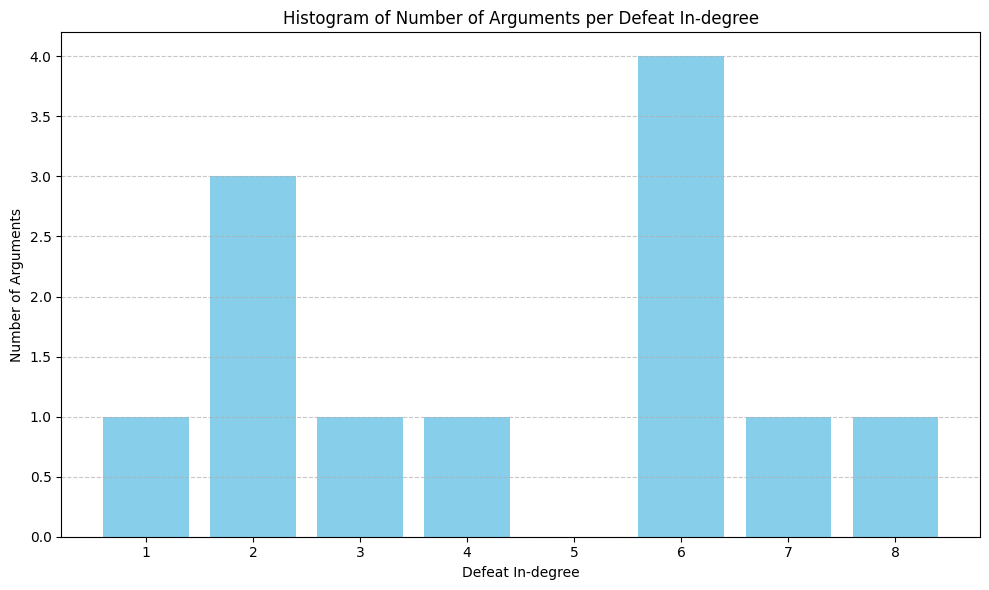

In [73]:
#chart generation


import sys
import os
import matplotlib.pyplot as plt
import io
import base64



defeat_in_degree_counts = {}



result, defended_by = deffeat_with_deff_by(new_arguments,pref)


#generate the graph
for defender, attackers in defended_by.items():
    in_degree = len(attackers)
    if in_degree not in defeat_in_degree_counts:
        defeat_in_degree_counts[in_degree] = 1
    else:
        defeat_in_degree_counts[in_degree] += 1

# generate_histogram(defeat_in_degree_counts)

# Generate the histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(defeat_in_degree_counts.keys(), defeat_in_degree_counts.values(), color='skyblue')
ax.set_xlabel('Defeat In-degree')
ax.set_ylabel('Number of Arguments')
ax.set_title('Histogram of Number of Arguments per Defeat In-degree')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Convert the plot to a base64 encoded image
img = io.BytesIO()
plt.savefig(img, format='png')
img.seek(0)
plot_url = base64.b64encode(img.getvalue()).decode()